# Multi-Fidelity Kolmogorov-Arnold Networks (MFKANs) in Neuromancer

This tutorial demonstrates the use of Multi-Fidelity Kolmogorov-Arnold Networks (MFKANs) for learning functions from high and low-fidelity data sources.

<!-- <img src="../figs/KAN_PINN_diagram.png" width="800">   -->


### References

[1] [Liu, Ziming, et al. (2024). KAN: Kolmogorov-Arnold Networks.](https://arxiv.org/abs/2404.19756)

[2] https://github.com/Blealtan/efficient-kan

[3] [Howard, Amanda A., et al. (2024) Multifidelity KANs.]


### Install Neuromancer
(Note: You can skip this step if running locally.)
(Note 2: Colab might ask you to restart your session after installing Neuromancer. Simply restart it when prompted.)

In [1]:
import os

# Check if the neuromancer directory already exists
if not os.path.isdir('neuromancer'):
    # Clone the specific branch of the repository
    !git clone --branch feature/mfkans https://github.com/pnnl/neuromancer.git

# Navigate to the repository directory
%cd neuromancer

# Install the repository with the required extras
!pip install -e .[docs,tests,examples]


### Import dependencies

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from neuromancer.dataset import DictDataset
from neuromancer.modules import blocks
from neuromancer.system import Node, System
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.loggers import LossLogger

# filter some user warnings from torch broadcast
import warnings
warnings.filterwarnings("ignore")


### Configure device and RNG seed

In [2]:
# Set default dtype to float32
torch.set_default_dtype(torch.float)
#PyTorch random number generator
torch.manual_seed(1234)
# Random number generators in other libraries
np.random.seed(1234)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Generate data

We will use the following jump function with a linear correlation. In this example we have sparse, high-fidelity data, which is not sufficient to capture the jump. 
$$
    y_L(x) = \begin{cases} 
      0.1\left[0.5(6x-2)^2 \sin(12x-4) + 10(x-0.5)-5\right] & x \leq 0.5 \\
      0.1\left[0.5(6x-2)^2 \sin(12x-4) + 10(x-0.5)-2\right] & x > 0.5  
   \end{cases}
$$
$$

y_H(x) = 2y_L(x) -2x + 2
$$

for $ x \in [0, 1].$ We take $ N_{LF}= 51 $ low-fidelity data points evenly distributed in $[0,1]$ and $ N_{HF} = 5 $ high-fidelity data points evenly spaced in $[0.1, 0.93]$. 

We also generate $N_{full} = 200$ data points to test low, high and multi-fidelity models.


In [3]:
# Define the low-fidelity and high-fidelity functions
def yL(x):
    y = torch.where(x < 0.5,
                    0.5*(6*x-2)**2 * torch.sin(12*x-4) + 10*(x-0.5)-5,
                    3 + 0.5*(6*x-2)**2 * torch.sin(12*x-4) + 10*(x-0.5)-5)
    return y / 10

def yH(x):
    return 2*(yL(x)) - 2*x + 2


# Generate three datasets: low-fidelity 
x_data_LF = torch.linspace(0, 1, 51).reshape(-1, 1)
y_data_LF = yL(x_data_LF)

x_data_HF = torch.linspace(.1, .93, 5).reshape(-1, 1)
y_data_HF = yH(x_data_HF)

x_data_full = torch.linspace(0, 1, 200).reshape(-1, 1)
y_data_full = yH(x_data_full)


In [4]:
# We will leverage Neuromancer's DictDataset to wrap the different datasets, giving them names
train_data_LF   = DictDataset({'x': x_data_LF.to(device), 'y': y_data_LF.to(device)}, name='train_LF')
train_data_HF   = DictDataset({'x': x_data_HF.to(device), 'y': y_data_HF.to(device)}, name='train_HF')
data_full       = DictDataset({'x': x_data_full.to(device), 'y': y_data_full.to(device)}, name='data_full')

# Here we leverage Torch's DataLoader class, that can use Neuromancer's DictDataset directly
batch_size_LF   = train_data_LF.datadict['x'].shape[0]
batch_size_HF   = train_data_HF.datadict['x'].shape[0]
batch_size_full = data_full.datadict['x'].shape[0]

train_loader_LF = torch.utils.data.DataLoader(train_data_LF, batch_size=batch_size_LF,
                                              collate_fn=train_data_LF.collate_fn,
                                              shuffle=False)

train_loader_HF = torch.utils.data.DataLoader(train_data_HF, batch_size=batch_size_HF,
                                              collate_fn=train_data_HF.collate_fn,
                                              shuffle=False)


data_loader_full = torch.utils.data.DataLoader(data_full, batch_size=batch_size_full,
                                              collate_fn=data_full.collate_fn,
                                              shuffle=False)


### Part 1: Create a single-fidelity KAN and train on low-fidelity data

In [5]:
# Define the low-fidelity KAN model
kan_LF = blocks.KANBlock(
    insize=1,                         # Input size
    outsize=1,                        # Output size
    hsizes=[5],                       # KAN shape is [insize, hsizes, outsize]
    grid_sizes=[5],                   # Grid size. Note: Neuromancer currently only support single-grid
    spline_order=3,                   # 3rd order splines
    grid_range=[0, 1],                # Range for grid normalization 
    base_activation=torch.nn.Sigmoid, # Basis function
).to(device)


# Symbolic wrapper of the LF KAN
kan_wrapper_LF = Node(kan_LF, ['x'], ['y_hat'], name='wrapper_LF')


#### Define symbolic variables and losses for low-fidelity KAN

In [6]:
# Define symbolic variables for LF model
x_LF = variable('x')
y_LF = variable('y')
y_hat_LF = variable('y_hat')

# Define losses
loss_data_LF = (y_LF == y_hat_LF)^2
loss_data_LF.name = "ref_loss_LF"

# Create loss function
loss_LF = PenaltyLoss(objectives=[loss_data_LF], constraints=[])

# Construct the optimization problem
problem_LF = Problem(nodes=[kan_wrapper_LF], loss=loss_LF, grad_inference=True)


#### Train the model defined by the `problem_LF`

Here we train a single-fidelity KAN with low-fidelity data alone.

In [7]:
# Create trainer for LF model
init_lr =0.005
epoch_verbose_lf = 100
num_epochs_lf=10000
logger_LF = LossLogger(args=None, savedir='test_LF', verbosity=epoch_verbose_lf, stdout=['train_LF_loss'])


trainer_LF = Trainer(
    problem_LF.to(device),
    train_data=train_loader_LF,
    dev_data=train_loader_LF,
    optimizer= torch.optim.Adam(problem_LF.parameters(), lr=init_lr),
    epoch_verbose=epoch_verbose_lf,
    logger=logger_LF,
    epochs=num_epochs_lf,
    train_metric='train_LF_loss',
    eval_metric='train_LF_loss',
    dev_metric='train_LF_loss',
    warmup=num_epochs_lf,
    device=device
)


# Train LF model
best_model_LF = trainer_LF.train()
problem_LF.load_state_dict(best_model_LF)
trained_model_LF = problem_LF.nodes[0]


Number of parameters: 100
epoch: 0	train_LF_loss: 0.28923	eltime:  0.02929
epoch: 100	train_LF_loss: 0.02990	eltime:  0.16434
epoch: 200	train_LF_loss: 0.00099	eltime:  0.29818
epoch: 300	train_LF_loss: 0.00057	eltime:  0.43077
epoch: 400	train_LF_loss: 0.00040	eltime:  0.56490
epoch: 500	train_LF_loss: 0.00030	eltime:  0.69451
epoch: 600	train_LF_loss: 0.00023	eltime:  0.82519
epoch: 700	train_LF_loss: 0.00017	eltime:  0.95411
epoch: 800	train_LF_loss: 0.00012	eltime:  1.08317
epoch: 900	train_LF_loss: 0.00008	eltime:  1.21211
epoch: 1000	train_LF_loss: 0.00005	eltime:  1.34099
epoch: 1100	train_LF_loss: 0.00003	eltime:  1.47295
epoch: 1200	train_LF_loss: 0.00002	eltime:  1.60520
epoch: 1300	train_LF_loss: 0.00001	eltime:  1.73394
epoch: 1400	train_LF_loss: 0.00001	eltime:  1.86303
epoch: 1500	train_LF_loss: 0.00001	eltime:  1.99600
epoch: 1600	train_LF_loss: 0.00001	eltime:  2.12536
epoch: 1700	train_LF_loss: 0.00000	eltime:  2.24995
epoch: 1800	train_LF_loss: 0.00000	eltime:  2.3779

### Part 2: Create a single-fidelity KAN and train on high-fidelity data

In [8]:
# Define the high-fidelity KAN model
kan_HF = blocks.KANBlock(
    insize=1,                          # Input size
    outsize=1,                         # Output size
    hsizes=[5],                        # KAN shape is [insize, hsizes, outsize]
    grid_sizes=[5],                    # Grid size. Note: Neuromancer currently only support single-grid
    spline_order=3,                    # 3rd order splines
    grid_range=[0, 1],                 # Range for grid normalization 
    base_activation=torch.nn.Sigmoid,  # Basis function
).to(device)

# Symbolic wrapper of the HF KAN
kan_wrapper_HF = Node(kan_HF, ['x'], ['y_hat'], name='wrapper_HF')


#### Define symbolic variables and losses for high-fidelity KAN

In [9]:
# Define symbolic variables for HF model
x_HF = variable('x')
y_HF = variable('y')
y_hat_HF = variable('y_hat')

# Define losses
loss_data_HF = (y_HF == y_hat_HF)^2
loss_data_HF.name = "ref_loss_HF"

# Create loss function
loss_HF = PenaltyLoss(objectives=[loss_data_HF], constraints=[])

# Construct the HF optimization problem
problem_HF = Problem(nodes=[kan_wrapper_HF], loss=loss_HF, grad_inference=True)


#### Train the model defined by the `problem_HF`

Here we train a single-fidelity KAN with the high-fidelity data alone.

In [10]:
# Create trainer for HF model
init_lr =0.005
epoch_verbose_hf = 100
num_epochs_hf=10000
logger_HF = LossLogger(args=None, savedir='test_HF', verbosity=epoch_verbose_hf, stdout=['train_HF_loss'])

trainer_HF = Trainer(
    problem_HF.to(device),
    train_data=train_loader_HF,
    dev_data=train_loader_HF,
    optimizer= torch.optim.Adam(problem_HF.parameters(), lr=init_lr),
    epoch_verbose=epoch_verbose_hf,
    logger=logger_HF,
    epochs=num_epochs_hf,
    train_metric='train_HF_loss',
    eval_metric='train_HF_loss',
    dev_metric='train_HF_loss',
    warmup=num_epochs_hf,
    device=device
)

# Train HF model
best_model_HF = trainer_HF.train()
problem_HF.load_state_dict(best_model_HF)
trained_model_HF = problem_HF.nodes[0]



Number of parameters: 100
epoch: 0	train_HF_loss: 0.61907	eltime:  0.00270
epoch: 100	train_HF_loss: 0.00110	eltime:  0.11428
epoch: 200	train_HF_loss: 0.00000	eltime:  0.21474
epoch: 300	train_HF_loss: 0.00000	eltime:  0.31609
epoch: 400	train_HF_loss: 0.00000	eltime:  0.41249
epoch: 500	train_HF_loss: 0.00000	eltime:  0.50663
epoch: 600	train_HF_loss: 0.00000	eltime:  0.60414
epoch: 700	train_HF_loss: 0.00000	eltime:  0.70197
epoch: 800	train_HF_loss: 0.00000	eltime:  0.79531
epoch: 900	train_HF_loss: 0.00000	eltime:  0.89208
epoch: 1000	train_HF_loss: 0.00000	eltime:  0.98970
epoch: 1100	train_HF_loss: 0.00000	eltime:  1.08312
epoch: 1200	train_HF_loss: 0.00000	eltime:  1.18582
epoch: 1300	train_HF_loss: 0.00000	eltime:  1.28156
epoch: 1400	train_HF_loss: 0.00000	eltime:  1.37587
epoch: 1500	train_HF_loss: 0.00000	eltime:  1.47076
epoch: 1600	train_HF_loss: 0.00000	eltime:  1.56531
epoch: 1700	train_HF_loss: 0.00000	eltime:  1.66175
epoch: 1800	train_HF_loss: 0.00000	eltime:  1.7575

### Part 3: Create a multi-fidelity KAN

This network leverages the low-fidelity model and the high-fidelity data.

In [11]:
# Define the multi-fidelity KAN model

# Here we use Neuromancer's MultiFidelityKAN block. The syntax is very similar to KANBlock!
kan_MF = blocks.MultiFidelityKAN(
    sfkan=kan_LF,                       # A trained, low-fidelity model
    insize=1,                           # Input size
    outsize=1,                          # Output size
    hsizes=[5],                         # Nonlinear KAN shape: [insize, hsizes, outsize]. Shape of linear KAN is always [insize, outsize].
    grid_sizes=[4],                     # Grid size. Note: Neuromancer currently only support single-grid
    spline_order=2,                     # 2nd order splines
    grid_range=[0, 1],                  # Range for grid normalization 
    alpha_init=0.1,                     # Initial value of learnable weight alpha, used in the convex combination of linear and nonlinear nets.
    base_activation=torch.nn.Sigmoid,   # Basis function
).to(device)

# Symbolic wrapper of the MF KAN
kan_wrapper_MF = Node(kan_MF, ['x'], ['y_hat'], name='kan_wrapper_MF')



#### Define symbolic variables and losses for multi-fidelity KAN

In [12]:
# Define symbolic variables for MF model
x_MF = variable('x')
y_MF = variable('y')
y_hat_MF = variable('y_hat')

# Define losses
loss_data_MF = (y_MF == y_hat_MF)^2
loss_data_MF.name = "ref_loss_MF"

# Create loss function
loss_MF = PenaltyLoss(objectives=[loss_data_MF], constraints=[])

# Construct the MF optimization problem
problem_MF = Problem(nodes=[kan_wrapper_MF], loss=loss_MF, grad_inference=True)


#### Train the model defined by the `problem_MF`

Here we train a multi-fidelity KAN using a low-fidelity, pre-trained model and high-fidelity, sparse data.

In [13]:
# Create trainer for MF model
num_epochs_mf = 20000
epoch_verbose_mf = 100
logger_MF = LossLogger(args=None, savedir='test_HF', verbosity=epoch_verbose_mf, stdout=['train_HF_loss'])


trainer_MF = Trainer(
    problem_MF.to(device),
    train_data=train_loader_HF,
    dev_data=train_loader_HF,
    optimizer=torch.optim.Adam(problem_MF.parameters(), lr=init_lr),
    epoch_verbose=epoch_verbose_mf,
    logger=logger_MF,
    epochs=num_epochs_mf,
    train_metric='train_HF_loss',
    eval_metric='train_HF_loss',
    dev_metric='train_HF_loss',
    warmup=num_epochs_mf,
    device=device
)

# Train MF model
best_model_MF = trainer_MF.train()
problem_MF.load_state_dict(best_model_MF)
trained_model_MF = problem_MF.nodes[0]


Number of parameters: 131
epoch: 0	train_HF_loss: 0.49794	eltime:  0.00381
epoch: 100	train_HF_loss: 0.05398	eltime:  0.19552
epoch: 200	train_HF_loss: 0.04039	eltime:  0.39655
epoch: 300	train_HF_loss: 0.01642	eltime:  0.58579
epoch: 400	train_HF_loss: 0.00703	eltime:  0.77287
epoch: 500	train_HF_loss: 0.00391	eltime:  0.95766
epoch: 600	train_HF_loss: 0.00253	eltime:  1.14821
epoch: 700	train_HF_loss: 0.00177	eltime:  1.32636
epoch: 800	train_HF_loss: 0.00129	eltime:  1.50102
epoch: 900	train_HF_loss: 0.00099	eltime:  1.68525
epoch: 1000	train_HF_loss: 0.00079	eltime:  1.87304
epoch: 1100	train_HF_loss: 0.00064	eltime:  2.04949
epoch: 1200	train_HF_loss: 0.00055	eltime:  2.21655
epoch: 1300	train_HF_loss: 0.00044	eltime:  2.40254
epoch: 1400	train_HF_loss: 0.00037	eltime:  2.59020
epoch: 1500	train_HF_loss: 0.00030	eltime:  2.76811
epoch: 1600	train_HF_loss: 0.00024	eltime:  2.96144
epoch: 1700	train_HF_loss: 0.00020	eltime:  3.13274
epoch: 1800	train_HF_loss: 0.00016	eltime:  3.3116

In [31]:
# Print value of final parameter alpha
for idx,alpha in enumerate(kan_MF.alpha):
    print(f"alpha_{idx} = {alpha}")


alpha_0 = Parameter containing:
tensor(0.3903, requires_grad=True)


### Plot results

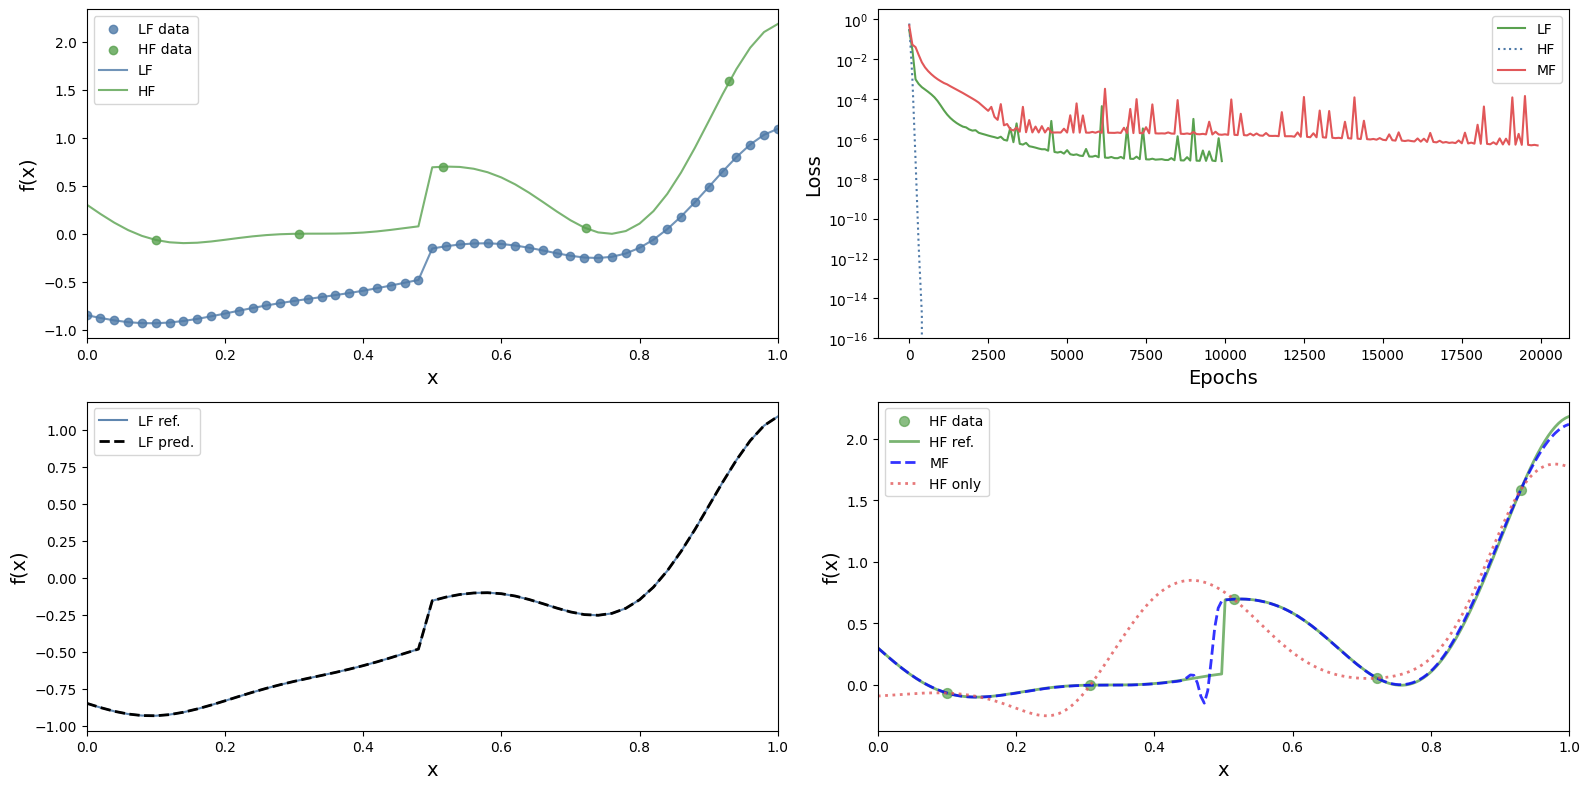

In [30]:
# Make predictions
preds_HF   = trained_model_HF(data_full.datadict)['y_hat'].cpu().detach().numpy()      # high-fidelity predictions of full data
preds_LF   = trained_model_LF(train_data_LF.datadict)['y_hat'].cpu().detach().numpy()  # low-fidelity predictions of low-fidelity data
preds_MF   = trained_model_MF(data_full.datadict)['y_hat'].cpu().detach().numpy()      # multi-fidelity predictions of full data

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 8), constrained_layout=True)

# Plot a): Sampled data and reference functions
axs[0, 0].scatter(x_data_LF.numpy(), y_data_LF.numpy(), c="#4e79a7", label='LF data', alpha=0.8)
axs[0, 0].scatter(x_data_HF.numpy(), y_data_HF.numpy(), c="#59a14f", label='HF data', alpha=0.8)
axs[0, 0].plot(x_data_LF.numpy(), yL(x_data_LF).numpy(), "#4e79a7", label='LF', alpha=0.8)
axs[0, 0].plot(x_data_LF.numpy(), yH(x_data_LF).numpy(), "#59a14f", label='HF', alpha=0.8)
axs[0, 0].set_xlim(0,1)
axs[0, 0].set_xlabel('x', fontsize=14)
axs[0, 0].set_ylabel('f(x)', fontsize=14)
axs[0, 0].legend(fontsize=10)

# Plot b): Evolution of losses vs epochs
losses_LF = trainer_LF.logger.get_losses()
losses_HF = trainer_HF.logger.get_losses()
losses_MF = trainer_MF.logger.get_losses()
epoch_losses_LF = range(1, len(losses_LF['train'])*epoch_verbose_lf+1, epoch_verbose_lf)
epoch_losses_HF = range(1, len(losses_HF['train'])*epoch_verbose_hf+1, epoch_verbose_hf)
epoch_losses_MF = range(1, len(losses_MF['train'])*epoch_verbose_mf+1, epoch_verbose_mf)

axs[0, 1].plot(epoch_losses_LF,losses_LF['train'], label='LF', color='#59a14f')
axs[0, 1].plot(epoch_losses_HF,losses_HF['train'], label='HF', linestyle='dotted', color='#4e79a7')
axs[0, 1].plot(epoch_losses_MF,losses_MF['train'], label='MF', color='#e15759') 
axs[0, 1].set_xlabel('Epochs', fontsize=14)
axs[0, 1].set_ylabel('Loss', fontsize=14)
axs[0, 1].set_yscale('log')
axs[0, 1].set_ylim(1e-16)
axs[0, 1].legend(fontsize=10)

# Plot c): LF predictions vs reference data
axs[1, 0].plot(x_data_LF.numpy(), yL(x_data_LF).numpy(), '#4e79a7', label='LF ref.', alpha=0.9)
axs[1, 0].plot(x_data_LF.numpy(), preds_LF, 'k--', label='LF pred.', linewidth=2)
axs[1, 0].set_xlim(0,1)
axs[1, 0].set_xlabel('x', fontsize=14)
axs[1, 0].set_ylabel('f(x)', fontsize=14)
axs[1, 0].legend(fontsize=10)

# Plot d): MF vs HF predictions and reference
axs[1,1].scatter(x_data_HF.numpy(), y_data_HF.numpy(), c="#59a14f", label='HF data', alpha=0.7, s=50)
axs[1,1].plot(x_data_full.numpy(), y_data_full.numpy(), '#59a14f', label='HF ref.', alpha=0.8, linewidth=2) # HF ref.
axs[1,1].plot(x_data_full.numpy(), preds_MF, '--b', label='MF', alpha=0.8, linewidth=2) # Predictions of MF model on full data
axs[1,1].plot(x_data_full.numpy(), preds_HF, '#e15759', linestyle='dotted', label='HF only', alpha=0.8, linewidth=2) # Predictions of HF model on full data
axs[1, 1].set_xlim(0,1)
axs[1, 1].set_xlabel('x', fontsize=14)
axs[1, 1].set_ylabel('f(x)', fontsize=14)
axs[1, 1].legend(fontsize=10)

plt.tight_layout()
plt.show()

# Optional: save your plot
# plt.savefig('MF_LF_Results_Inference_Neuromancer.png', dpi=300, bbox_inches='tight')

